In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = "black"
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

MC Run

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

from data_simulation.simulate_data import Experiment
from cluster_initialization.init_class import Cluster_initialization

from em_algorithm.processing_results import process_parallel_results
from em_algorithm.em_funcs import run_EM
from model_selection.scoreboard import create_scoreboard

from model_selection.run import model_selection_run
from mc_simulation.preparation import initialize_results_dict

pd.options.mode.chained_assignment = None 

N_data = 100 # number of experiments

experiment_params = {
    "cluster_number_range": (1,5),
    "min_datapoints": 5
}

em_params = {
    "max_iter": 500,
    "em_tol": 1e-5,
    "min_mix_coef": 0.00
}

cluster_init_params = {
    "N_cluster_max": 7,
    "N_runs_per_clusternumber": 10
}
parallel_params = {
    "n_jobs": 10
}

init_routines = ["OPTICS", "random_inside"]

run_results = initialize_results_dict(init_routines=init_routines)

run_data = {}
#TODO try - error; save successfull experiemnts as boolean; save errors too
for n_data in tqdm(range(N_data)):
    exp = Experiment(max_cluster_number = max_cluster_number)
    while exp.X.shape[0]<5:  # because optics needs min sample 5
        exp = Experiment(max_cluster_number = max_cluster_number)
    df, X = exp.df, exp.X
    run_data[n_data] = exp
    for init in init_routines:
        cluster_init = Cluster_initialization(df, routine = init)
        # start
        df_scores, results = model_selection_run(X, cluster_init, em_params, cluster_init_params, parallel_params)
        # end

        run_results[init]["init_params"].append(cluster_init)
        run_results[init]["df_scores"].append(df_scores)
        run_results[init]["em_results"].append(results["params"])


In [32]:
def cluster_experiment(experiment_params, init_routine, cluster_init_params, em_params):
    experiment = Experiment(**experiment_params)
    cluster_init = Cluster_initialization(experiment.df, routine=init_routine)
    cluster_init.sample(**cluster_init_params)
    em = EM(**em_params)
    em.run(experiment.X, cluster_init=cluster_init)
    return em.results.get_dict()


def merge_parallel_results(parallel_results):
    merged_results = {key: [] for key in parallel_results[0].keys()}
    merged_results["dataset"] = []
    for dataset, result in enumerate(parallel_results):
        merged_results["dataset"] = merged_results["dataset"] + [dataset for _i in range(len(result["iterations"]))]
        for key, val in result.items():
            merged_results[key] = merged_results[key] + val
    return merged_results

def merge_init_routine_results(results):
    merged_results = {key: [] for key in results[list(results.keys())[0]].keys()}
    merged_results["init_routine"] = []
    for init_routine, result in results.items():
        merged_results["init_routine"] = merged_results["init_routine"] + [init_routine for _i in range(len(results[init_routine]["iterations"]))]
        for key, val in result.items():
            merged_results[key] = merged_results[key] + val
    return merged_results

import pandas as pd
def create_df_from_results(results, non_df_cols = ["inferred_mixtures", "starting_values"]):
    df_result = pd.DataFrame.from_dict({key: val for key, val in results.items() if key not in non_df_cols})
    df_result = df_result.reset_index()
    df_result.rename(columns={"model_idxs": "em_model_idx","index": "model_idx"}, inplace=True)
    return df_result, {key: val for key, val in results.items() if key in non_df_cols}

In [33]:
from tqdm import tqdm
from copy import deepcopy
from joblib import Parallel, delayed

from data_simulation.simulate_data import Experiment
from cluster_initialization.init_class import Cluster_initialization
from em_algorithm.em_class import EM

N_data = 5 # number of experiments

experiment_params = {
    "cluster_number_range": (1,5),
    "min_datapoints": 5
}

em_params = {
    "max_iter": 10,
    "em_tol": 1e-5,
    "min_mix_coef": 0.02
}

cluster_init_params = {
    "N_cluster_max": 5,
    "N_runs_per_clusternumber": 10
}
parallel_params = {
    "n_jobs": 10
}

init_routines = ["OPTICS", "random_inside"]




init_routines = ["random_inside", "OPTICS"]
results = {}
for init_routine in tqdm(init_routines):
    parallel = Parallel(**parallel_params) 
    parallel_results = parallel(delayed(cluster_experiment)(experiment_params, init_routine, cluster_init_params, em_params) for _i in range(N_data))
    results[init_routine] = merge_parallel_results(parallel_results)

merged_results = merge_init_routine_results(results)
df_results, model_data = create_df_from_results(merged_results)

100%|██████████| 2/2 [01:01<00:00, 30.80s/it]


In [24]:
len(parallel_results)

5

In [19]:
len(results["random_inside"]["iterations"])

250

In [34]:
merged_results = merge_init_routine_results(results)
df_results, model_data = create_df_from_results(merged_results)

In [40]:
df_results[df_results.dataset < 2].head(60)

,model_idx,iterations,execution_time,total_execution_time,total_iterations,em_model_idx,reiterations,dataset,init_routine
0,0,2,0.013873,0.013873,2,0,0,0,random_inside
1,1,2,0.011728,0.011728,2,1,0,0,random_inside
2,2,2,0.012952,0.012952,2,2,0,0,random_inside
3,3,2,0.008311,0.008311,2,3,0,0,random_inside
4,4,2,0.008745,0.008745,2,4,0,0,random_inside
5,5,2,0.009147,0.009147,2,5,0,0,random_inside
6,6,2,0.010016,0.010016,2,6,0,0,random_inside
7,7,2,0.007342,0.007342,2,7,0,0,random_inside
8,8,2,0.009392,0.009392,2,8,0,0,random_inside
9,9,2,0.013693,0.013693,2,9,0,0,random_inside


ValueError: All arrays must be of the same length

In [34]:
df_results

,model_idx,iterations,execution_time,total_execution_time,total_iterations_time,em_model_idx,reiterations,init_routine
0,0,2,0.249417,0.249417,2,0,0,random_inside
1,1,2,0.009658,0.009658,2,1,0,random_inside
2,2,2,0.011415,0.011415,2,2,0,random_inside
3,3,3,0.045743,0.045743,3,3,0,random_inside
4,4,2,0.013638,0.013638,2,4,0,random_inside
...,...,...,...,...,...,...,...,...
565,565,100,1.688883,1.688883,100,10,0,OPTICS
566,566,100,1.376116,1.376116,100,11,0,OPTICS
567,567,100,1.405754,1.405754,100,12,0,OPTICS
568,568,82,1.185342,1.185342,82,13,0,OPTICS


In [7]:
results.keys()

dict_keys(['random_inside', 'OPTICS'])

In [21]:
merged_results.keys()

dict_keys(['inferred_mixtures', 'iterations', 'execution_time', 'starting_values', 'total_execution_time', 'total_iterations_time', 'model_idxs', 'reiterations'])

45.645895063332624

In [2]:
from plotting.plot_funcs import plot_cluster

# logger! 

#plot_cluster(exp.df, "cluster", title="True Clusters")

In [4]:
from mc_simulation.after_processing import process_run_results2

df_total = process_run_results2(run_results, run_data)
df_total = df_total[df_total.dataset!=65]

OPTICS


66it [00:58,  1.12it/s]


random_inside


65it [01:24,  1.31s/it]


In [5]:
df_total

,param_index,iter_steps,execution_time,ll,AIC,BIC,MML,silhouette,CH,N_cluster,...,silhouette_rank,CH_rank,TOTAL_score,TOTAL_rank,Total_score_prop,Total_prop_rank,init_routine,dataset,True_Cluster_number,identified_cluster
0,8,16,0.471145,-67.533587,75.533587,85.706766,79.782950,0.465293,387.794836,2,...,1,1,6,1,1.000000,1,OPTICS,0,2,2.0
1,11,17,0.146458,-67.533689,75.533689,85.706868,79.783055,0.465293,387.794836,2,...,1,1,10,2,0.999999,2,OPTICS,0,2,2.0
2,9,29,0.479865,-67.534046,75.534046,85.707225,79.783423,0.465293,387.794836,2,...,1,1,14,3,0.999995,3,OPTICS,0,2,2.0
3,10,33,0.200122,-67.534165,75.534165,85.707344,79.783544,0.465293,387.794836,2,...,1,1,18,4,0.999994,4,OPTICS,0,2,2.0
4,6,30,0.498867,-67.534173,75.534173,85.707352,79.783552,0.465293,387.794836,2,...,1,1,22,5,0.999994,5,OPTICS,0,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,60,43,4.229331,-688.755533,716.755533,766.111874,726.400749,-0.037631,78.971615,7,...,33,40,345,55,0.131375,66,random_inside,64,5,1.0
66,69,46,3.866123,-676.981635,704.981635,754.337976,708.683395,-0.167400,77.434016,7,...,45,41,348,56,0.130495,67,random_inside,64,5,1.0
67,56,7,0.591423,-684.373546,708.373546,750.678981,710.393029,-0.216570,35.419310,6,...,47,46,358,57,0.107197,68,random_inside,64,5,1.0
68,63,72,4.180724,-695.085420,723.085420,772.441761,732.881312,-0.151151,81.956041,7,...,44,38,358,57,0.076056,69,random_inside,64,5,1.0


In [6]:
run_results["OPTICS"]['init_params'][0]

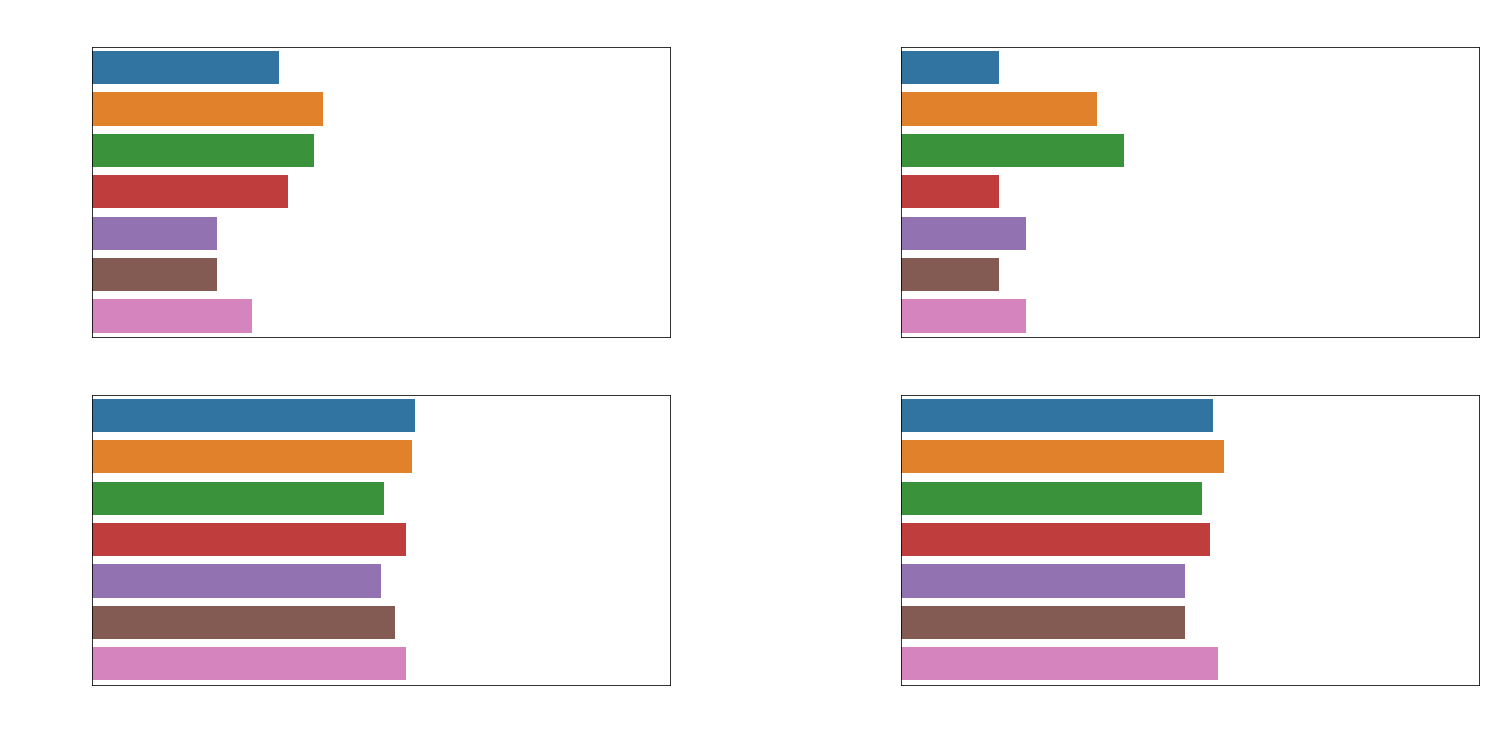

In [7]:
import seaborn as sns
from plotting.mc_simulation.criteria_performance import add_score_performance_plot, add_score_performance_plot_identified
from plotting.mc_simulation.init_performance import add_init_rout_performance_plot#, add_init_rout_performance_plot_identified

settings = {
    "ax_title_size": 18,
    "axis_label_size": 18
}

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 10)
fig.suptitle("Analysis of MC-Run", color="white", size=30)
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.4)
add_score_performance_plot(df_total, axs[0,0], settings, "OPTICS")
add_score_performance_plot(df_total, axs[0,1], settings, "random_inside")
add_score_performance_plot_identified(df_total, axs[1,0], settings, "OPTICS")
add_score_performance_plot_identified(df_total, axs[1,1], settings, "random_inside")

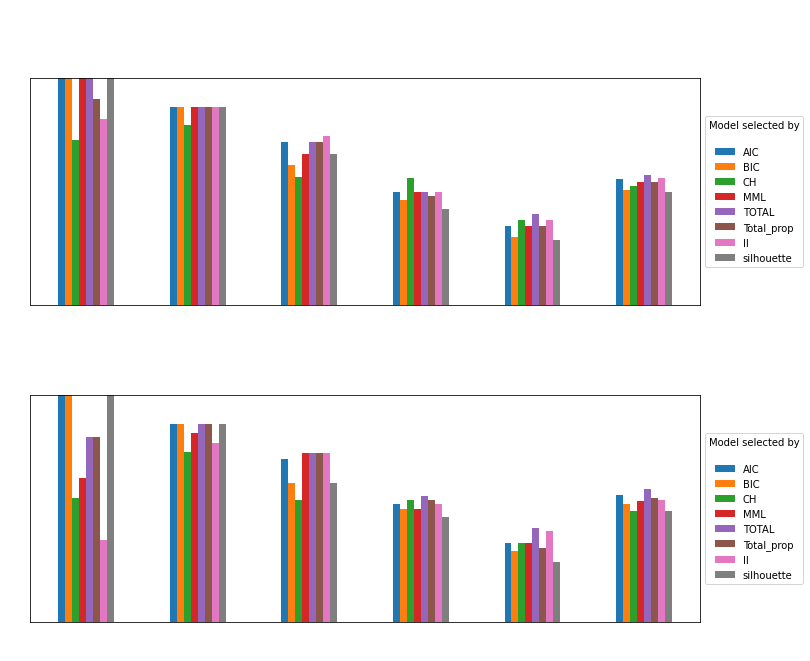

In [17]:
from plotting.mc_simulation.criteria.plot import plot_comparison_criteria
settings = {
    "sup_title_size": 25
}
fig, data = plot_comparison_criteria(df_total, settings)
fig

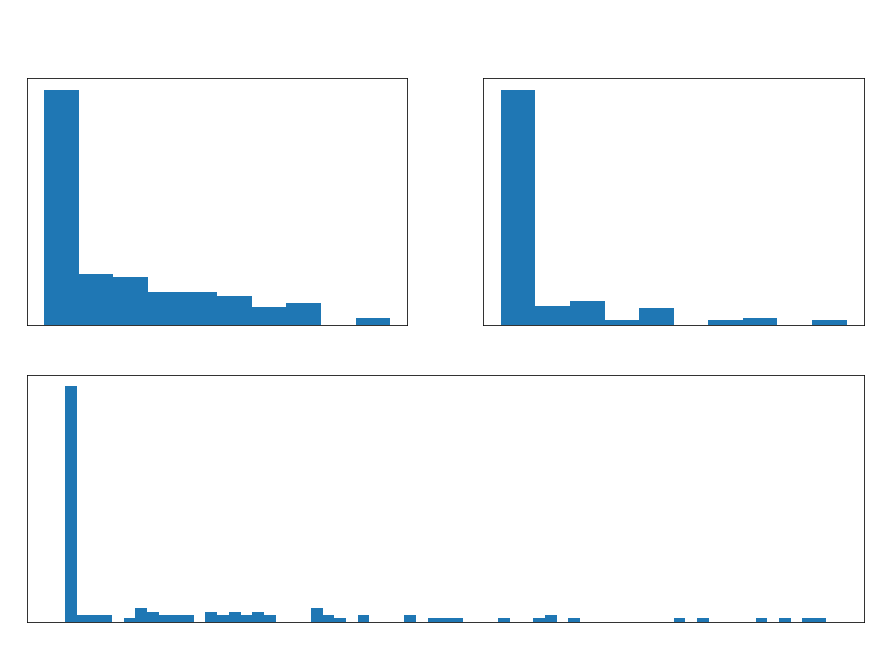

In [16]:
from plotting.mc_simulation.best_model_position.plot import plot_ranks_of_best_model
rank = "ll_rank"
N_experiments, N_runs_per_clusternumber = 65, 10
#TODO CH_rank has best intra but worst inter rank profile -> more research
plot_ranks_of_best_model(df_total, rank, N_experiments, N_runs_per_clusternumber)#, init_routine="random_inside")
    

In [10]:
pd.set_option('display.max_columns', None)
#cols = [ 'param_index', 'll', 'AIC', 'BIC', 'silhouette', 'll_rank', 'AIC_rank', 'BIC_rank',"TOTAL_rank", 'silhouette_rank',"CH_rank", 'identified_cluster', "N_cluster",'True_Cluster_number']
dataset = 30
init_routine = "random_inside"
criterion = "AIC"

df_select = df_total.loc[(df_total.dataset == dataset) & (df_total.init_routine == init_routine),:].sort_values(criterion)
#df_select = df_select[df_select.identified_cluster == df_select.identified_cluster.max()]
df_select.head(25)

,param_index,iter_steps,execution_time,ll,AIC,BIC,MML,silhouette,CH,N_cluster,ll_rank,AIC_rank,BIC_rank,MML_rank,silhouette_rank,CH_rank,TOTAL_score,TOTAL_rank,Total_score_prop,Total_prop_rank,init_routine,dataset,True_Cluster_number,identified_cluster
0,22,75,1.352957,-319.967510,331.967510,350.343080,338.749662,0.435028,377.280404,3,2,1,1,1,8,1,14,1,0.979633,1,random_inside,30,5,2.0
5,40,135,2.316272,-319.939655,339.939655,370.565605,345.353427,0.418869,292.701250,5,1,2,9,2,9,7,30,2,0.934992,6,random_inside,30,5,3.0
8,41,500,7.677209,-320.489729,340.489729,371.115679,346.947744,0.365739,257.114699,5,3,3,15,3,14,12,50,8,0.913866,9,random_inside,30,5,5.0
1,23,54,1.038958,-330.551549,342.551549,360.927119,347.914368,0.488866,191.079429,3,12,4,4,4,2,22,48,7,0.948162,2,random_inside,30,5,1.0
2,36,328,3.410022,-328.039384,344.039384,368.540145,351.468195,0.483068,311.351246,4,9,5,6,11,3,3,37,3,0.935223,3,random_inside,30,5,4.0
3,33,292,2.234441,-328.039418,344.039418,368.540178,351.468228,0.483068,311.351246,4,10,6,7,12,3,2,40,4,0.935222,4,random_inside,30,5,4.0
4,35,304,1.840744,-328.040694,344.040694,368.541455,351.469455,0.483068,311.351246,4,11,7,8,13,3,2,44,5,0.935216,5,random_inside,30,5,4.0
6,19,77,0.501458,-336.099687,344.099687,356.350067,351.176758,0.445240,302.913464,2,19,8,2,7,6,5,47,6,0.925985,7,random_inside,30,5,1.0
7,15,80,0.509424,-336.099714,344.099714,356.350094,351.176784,0.445240,302.913464,2,20,9,3,8,6,5,51,9,0.925985,8,random_inside,30,5,1.0
9,49,193,3.133234,-324.900814,344.900814,375.526764,351.392483,0.397429,269.851712,5,5,10,21,9,11,10,66,10,0.902998,10,random_inside,30,5,5.0


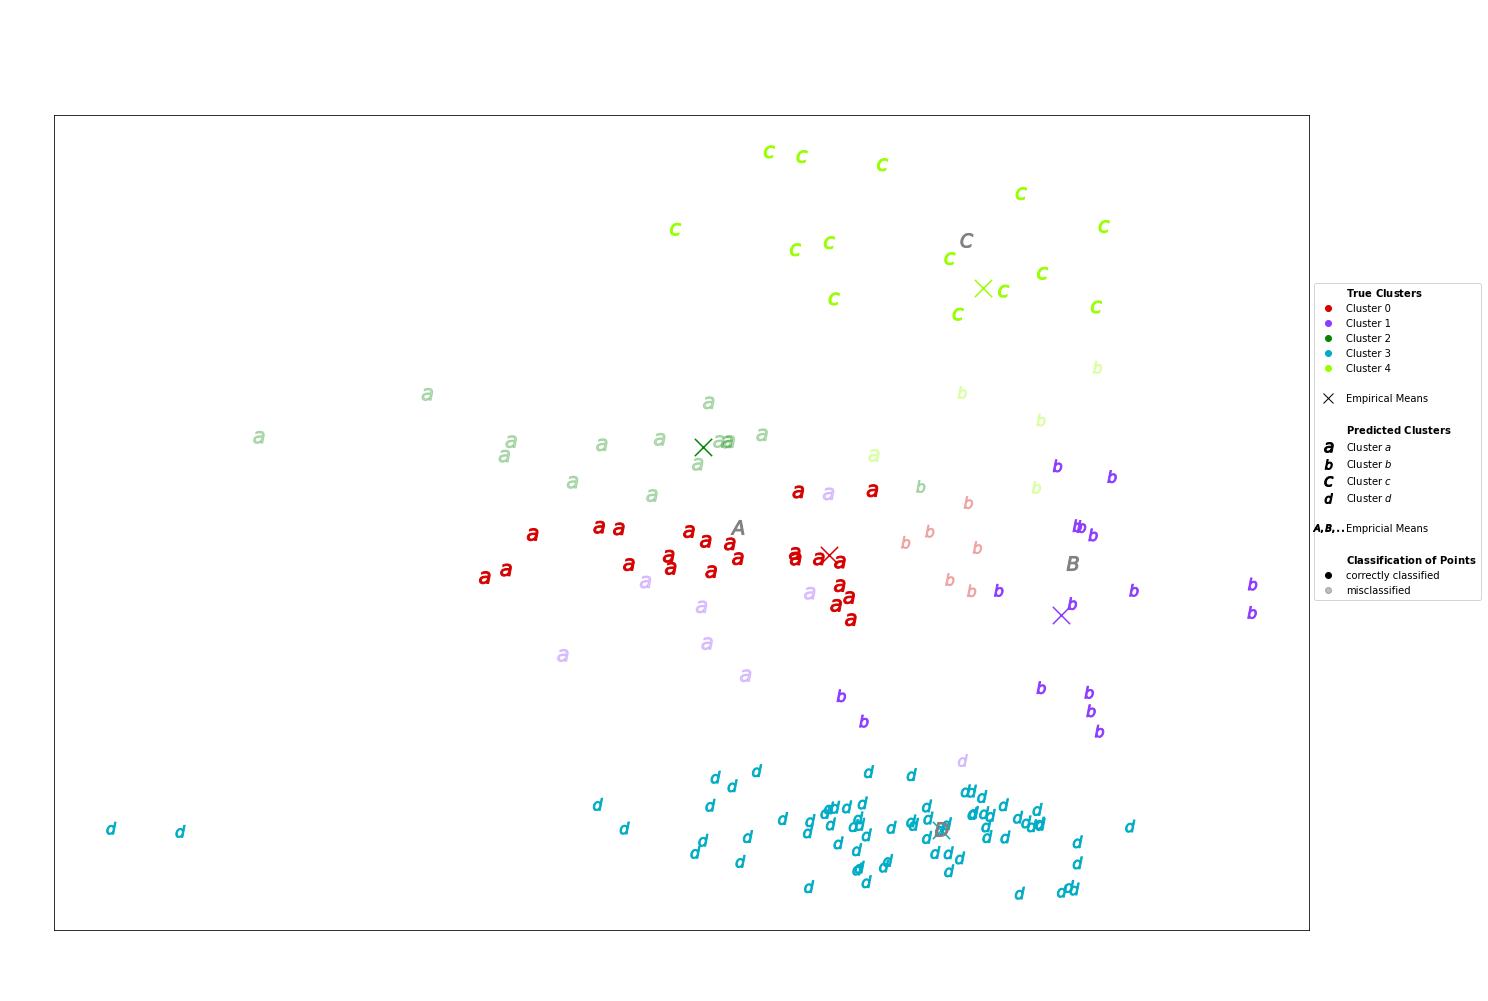

In [14]:
from plotting.clustering_assessment.plot import plot_clustering_assessment
init_routine = "random_inside"
dataset = 30
param_idx = 36
criterion = "TOTAL_rank"

plot_clustering_assessment(run_data, run_results, init_routine, dataset, criterion, param_idx=param_idx)

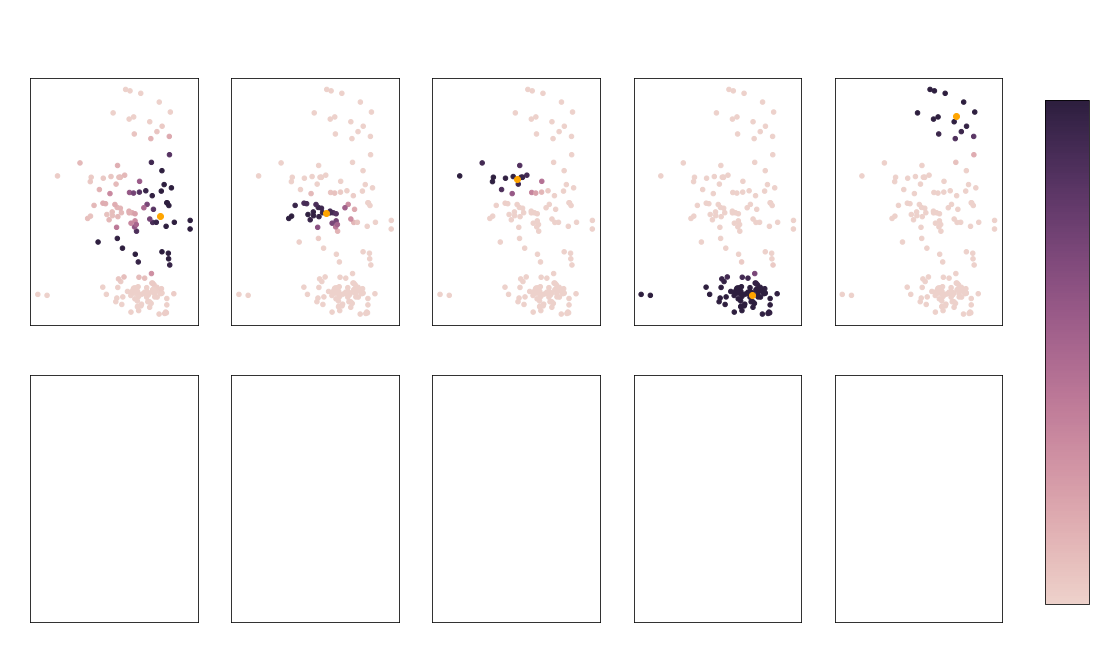

In [12]:
from plotting.plot_funcs import plot_responsibilities

plot_responsibilities(run_data[dataset], run_results[init_routine]["em_results"][dataset][param_idx]) 